In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import sys
import warnings
import gensim
from gensim.utils import simple_preprocess

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import chakin  
import os


import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, GlobalMaxPool1D, Bidirectional,GRU
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.utils import class_weight

from wordcloud import WordCloud 

C:\Users\myl94\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# read file
Netflix = pd.read_csv('netflix_titles.csv')

In [3]:
Netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
Netflix.shape

(7787, 12)

In [5]:
# check if there are some repeat values
Netflix.describe(include='all')

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
count,7787,7787,7787,5398,7069,7280,7777,7787.000000,7780,7787,7787,7787
unique,7787,2,7787,4049,6831,681,1565,NaN,14,216,492,7769
top,s6492,Movie,Marvel's Iron Man & Hulk: Heroes United,"Raúl Campos, Jan Suter",David Attenborough,United States,"January 1, 2020",NaN,TV-MA,1 Season,Documentaries,A surly septuagenarian gets another chance at ...
freq,1,5377,1,18,18,2555,118,NaN,2863,1608,334,3
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013.932580,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.757395,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,NaN,NaN,NaN,NaN


In [6]:
# create a new dataframe that contains title, type, country, rating, listed_in and description
description_category = Netflix[['title','type','country','rating','listed_in','description']]
description_category['listed_in'] = description_category['listed_in'].apply(lambda x: x.split(', '))
description_category

C:\Users\myl94\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,title,type,country,rating,listed_in,description
0,3%,TV Show,Brazil,TV-MA,"[International TV Shows, TV Dramas, TV Sci-Fi ...",In a future where the elite inhabit an island ...
1,7:19,Movie,Mexico,TV-MA,"[Dramas, International Movies]",After a devastating earthquake hits Mexico Cit...
2,23:59,Movie,Singapore,R,"[Horror Movies, International Movies]","When an army recruit is found dead, his fellow..."
3,9,Movie,United States,PG-13,"[Action & Adventure, Independent Movies, Sci-F...","In a postapocalyptic world, rag-doll robots hi..."
4,21,Movie,United States,PG-13,[Dramas],A brilliant group of students become card-coun...
...,...,...,...,...,...,...
7782,Zozo,Movie,"Sweden, Czech Republic, United Kingdom, Denmar...",TV-MA,"[Dramas, International Movies]",When Lebanon's Civil War deprives Zozo of his ...
7783,Zubaan,Movie,India,TV-14,"[Dramas, International Movies, Music & Musicals]",A scrappy but poor boy worms his way into a ty...
7784,Zulu Man in Japan,Movie,NaN,TV-MA,"[Documentaries, International Movies, Music & ...","In this documentary, South African rapper Nast..."
7785,Zumbo's Just Desserts,TV Show,Australia,TV-PG,"[International TV Shows, Reality TV]",Dessert wizard Adriano Zumbo looks for the nex...


In [7]:
# seperate categories from each list_in to 3 different columns
columns = ['category_1', 'category_2', 'category_3']
cat = pd.DataFrame(description_category['listed_in'].to_list(), columns = columns)
cat.head()

,category_1,category_2,category_3
0,International TV Shows,TV Dramas,TV Sci-Fi & Fantasy
1,Dramas,International Movies,None
2,Horror Movies,International Movies,None
3,Action & Adventure,Independent Movies,Sci-Fi & Fantasy
4,Dramas,None,None


In [8]:

genres_1 = cat.category_1.unique()
genres_2 = cat.category_2.unique()
genres_3 = cat.category_3.unique()

genres = np.concatenate([genres_1, genres_2,genres_3])
genres = list(dict.fromkeys(genres))
genres = [x for x in genres if x is not None]

len(genres)

42

In [9]:
#  show the each categories 
cat = pd.concat([cat,pd.DataFrame(columns = list(genres))])
cat.fillna(0, inplace = True)
cat

,category_1,category_2,category_3,International TV Shows,Dramas,Horror Movies,Action & Adventure,Crime TV Shows,Documentaries,Independent Movies,...,TV Sci-Fi & Fantasy,Romantic Movies,Spanish-Language TV Shows,LGBTQ Movies,Science & Nature TV,Korean TV Shows,Faith & Spirituality,Teen TV Shows,TV Mysteries,TV Thrillers
0,International TV Shows,TV Dramas,TV Sci-Fi & Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dramas,International Movies,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Horror Movies,International Movies,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Action & Adventure,Independent Movies,Sci-Fi & Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dramas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,Dramas,International Movies,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7783,Dramas,International Movies,Music & Musicals,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7784,Documentaries,International Movies,Music & Musicals,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7785,International TV Shows,Reality TV,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
row = 0
for genre in cat['category_1']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1


In [11]:
row = 0
for genre in cat['category_2']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1


In [12]:
# count each type of category for each movie/TV
row = 0
for genre in cat['category_3']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1
cat

,category_1,category_2,category_3,International TV Shows,Dramas,Horror Movies,Action & Adventure,Crime TV Shows,Documentaries,Independent Movies,...,TV Sci-Fi & Fantasy,Romantic Movies,Spanish-Language TV Shows,LGBTQ Movies,Science & Nature TV,Korean TV Shows,Faith & Spirituality,Teen TV Shows,TV Mysteries,TV Thrillers
0,International TV Shows,TV Dramas,TV Sci-Fi & Fantasy,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Dramas,International Movies,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Horror Movies,International Movies,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Action & Adventure,Independent Movies,Sci-Fi & Fantasy,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Dramas,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,Dramas,International Movies,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7783,Dramas,International Movies,Music & Musicals,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7784,Documentaries,International Movies,Music & Musicals,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7785,International TV Shows,Reality TV,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#  add details such as, title, type, rating, country, description to the cat dataframe
title = pd.concat([description_category['title']], axis=1)
description = pd.concat([description_category['description']], axis=1)
Type = pd.concat([description_category['type']], axis=1)
rating = pd.concat([description_category['rating']],axis=1)
country = pd.concat([description_category['country']],axis=1)
cat = pd.concat([title, Type, rating,country,description,cat.loc[:,"International TV Shows":]], join = 'outer', axis = 1)
cat

,title,type,rating,country,description,International TV Shows,Dramas,Horror Movies,Action & Adventure,Crime TV Shows,...,TV Sci-Fi & Fantasy,Romantic Movies,Spanish-Language TV Shows,LGBTQ Movies,Science & Nature TV,Korean TV Shows,Faith & Spirituality,Teen TV Shows,TV Mysteries,TV Thrillers
0,3%,TV Show,TV-MA,Brazil,In a future where the elite inhabit an island ...,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,7:19,Movie,TV-MA,Mexico,After a devastating earthquake hits Mexico Cit...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23:59,Movie,R,Singapore,"When an army recruit is found dead, his fellow...",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,Movie,PG-13,United States,"In a postapocalyptic world, rag-doll robots hi...",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,21,Movie,PG-13,United States,A brilliant group of students become card-coun...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,Zozo,Movie,TV-MA,"Sweden, Czech Republic, United Kingdom, Denmar...",When Lebanon's Civil War deprives Zozo of his ...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7783,Zubaan,Movie,TV-14,India,A scrappy but poor boy worms his way into a ty...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7784,Zulu Man in Japan,Movie,TV-MA,NaN,"In this documentary, South African rapper Nast...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7785,Zumbo's Just Desserts,TV Show,TV-PG,Australia,Dessert wizard Adriano Zumbo looks for the nex...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#  show the desciption and all categories
description_category = pd.concat([description_category['description'], 
                                     cat.loc[:,"International TV Shows":]],
                                    axis=1)
description_category

,description,International TV Shows,Dramas,Horror Movies,Action & Adventure,Crime TV Shows,Documentaries,Independent Movies,Comedies,Sports Movies,...,TV Sci-Fi & Fantasy,Romantic Movies,Spanish-Language TV Shows,LGBTQ Movies,Science & Nature TV,Korean TV Shows,Faith & Spirituality,Teen TV Shows,TV Mysteries,TV Thrillers
0,In a future where the elite inhabit an island ...,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,After a devastating earthquake hits Mexico Cit...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"When an army recruit is found dead, his fellow...",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"In a postapocalyptic world, rag-doll robots hi...",0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A brilliant group of students become card-coun...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,When Lebanon's Civil War deprives Zozo of his ...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7783,A scrappy but poor boy worms his way into a ty...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7784,"In this documentary, South African rapper Nast...",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7785,Dessert wizard Adriano Zumbo looks for the nex...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


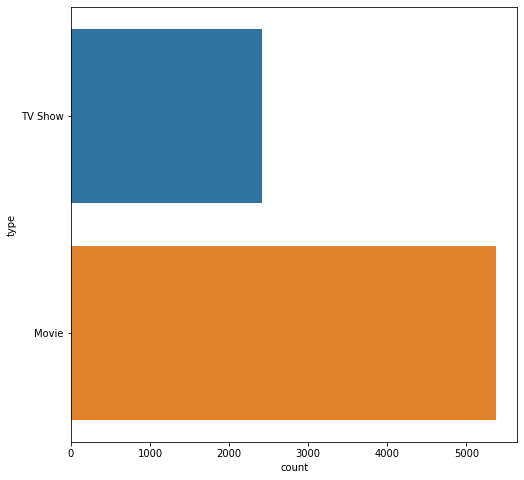

In [15]:
# show the plot figures of total number of TV show and Movie
plt.figure(figsize = (8,8))
sns.countplot(y = 'type',data = cat)

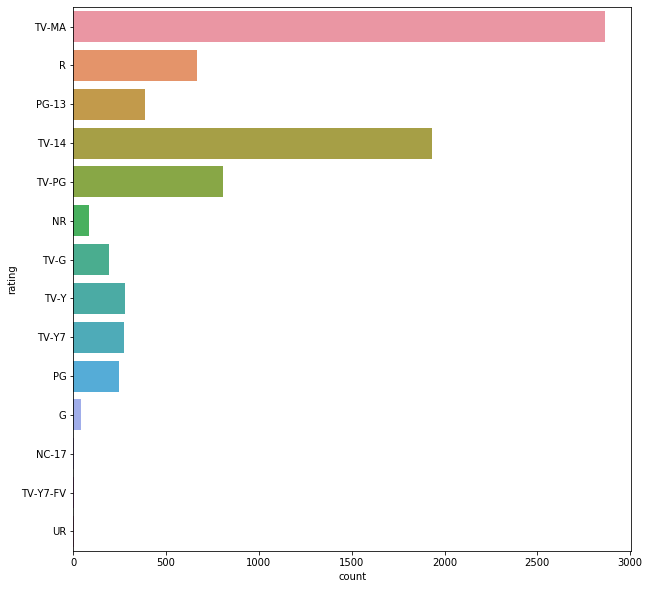

In [16]:
# show the count of each rating

plt.figure(figsize = (10, 10))
sns.countplot(y = "rating", data = cat)

In [17]:
# show the count for each category
count = pd.DataFrame()
count['cat'] = cat.columns[5:]
count['count'] = cat.iloc[:,5:].sum().values
count.sort_values(['count'], inplace=True, ascending=False)
count

,cat,count
15,International Movies,2437
1,Dramas,2106
7,Comedies,1471
0,International TV Shows,1199
5,Documentaries,786
3,Action & Adventure,721
26,TV Dramas,704
6,Independent Movies,673
18,Children & Family Movies,532
33,Romantic Movies,531


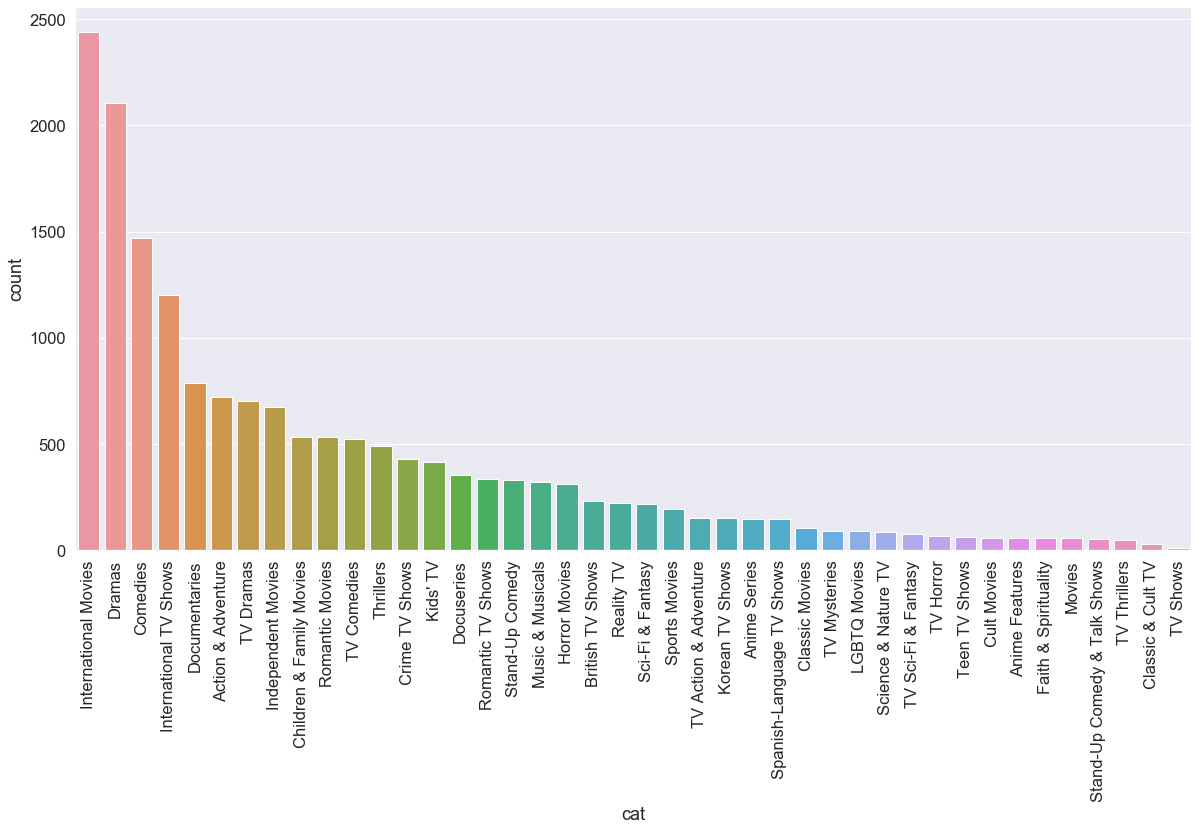

In [18]:
# show the plot figure of count of each category
plt.figure(figsize = (20,10))
sns.set(font_scale = 1.5)
sns.barplot(count['cat'], count['count'])
plt.xticks(rotation='vertical')
plt.show()

In [19]:
# since the category is not balanced, calculate class_weight for neural network in the future
class_weights = class_weight.compute_class_weight('balanced',np.unique(count['count']),count['count'])
class_weights = dict(enumerate(class_weights))

C:\Users\myl94\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[  12   27   50   52   56   57   59   60   69   76   85   90  103  147
  148  150  196  218  222  232  312  321  329  333  353  414  427  491
  525  531  532  673  704  721  786 1199 1471 2106 2437], y=15    2437
1     2106
7     1471
0     1199
5      786
3      721
26     704
6      673
18     532
33     531
11     525
21     491
4      427
17     414
12     353
30     333
23     329
25     321
2      312
14     232
10     222
16     218
8      196
28     150
37     150
9      148
34     147
20     103
40      90
35      90
36      85
32      76
27      69
39      60
31      59
24      57
38      57
13      56
22      52
41      50
29      27
19      12
Name: count, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [20]:
#  clean the data by remove stop_words
stemmer = SnowballStemmer("english")
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['cant','didnt','doesnt','dont','goes','isnt','hes',\
        'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
        've', 're', 'vs'])

In [21]:
def preprocess(text):
    letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(text))     # Column and row to search    

    words = letters_only.lower().split()     
    stops = set(stop_words)      
    meaningful_words = [w for w in words if not w in stops]      
    return (" ".join(meaningful_words))    

In [22]:

cat['description'] = cat['description'].apply(preprocess)
cat['description'][0]


'future elite inhabit island paradise far crowded slums get one chance join saved squalor'

In [23]:
# Obtain the total words present in the dataset
list_of_words = []
for i in cat.description:
    for each in i.split(' '):
        list_of_words.append(each)
list_of_words

['future',
 'elite',
 'inhabit',
 'island',
 'paradise',
 'far',
 'crowded',
 'slums',
 'get',
 'one',
 'chance',
 'join',
 'saved',
 'squalor',
 'devastating',
 'earthquake',
 'hits',
 'mexico',
 'city',
 'trapped',
 'survivors',
 'walks',
 'life',
 'wait',
 'rescued',
 'trying',
 'desperately',
 'stay',
 'alive',
 'army',
 'recruit',
 'found',
 'dead',
 'fellow',
 'soldiers',
 'forced',
 'confront',
 'terrifying',
 'secret',
 'haunting',
 'jungle',
 'island',
 'training',
 'camp',
 'postapocalyptic',
 'world',
 'rag',
 'doll',
 'robots',
 'hide',
 'fear',
 'dangerous',
 'machines',
 'exterminate',
 'brave',
 'newcomer',
 'joins',
 'group',
 'brilliant',
 'group',
 'students',
 'become',
 'card',
 'counting',
 'experts',
 'intent',
 'swindling',
 'millions',
 'las',
 'vegas',
 'casinos',
 'playing',
 'blackjack',
 'genetics',
 'professor',
 'experiments',
 'treatment',
 'comatose',
 'sister',
 'blends',
 'medical',
 'shamanic',
 'cures',
 'unlocks',
 'shocking',
 'side',
 'effect',
 '

In [24]:
len(list_of_words)

113420

In [25]:
total_words = len(list(set(list_of_words)))
total_words

17805

In [26]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in cat.description:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 29


In [27]:
# seed value for random number generators to obtain reproducible results

RANDOM_SEED = 9999

In [28]:
# split train set and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cat['description'], 
                                                    cat[description_category.columns[1:-2]],
                                                    random_state = RANDOM_SEED,
                                                    test_size=0.3)

In [29]:
# Convert description text documents to a matrix of token counts
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)


In [30]:
len(train_sequences)

5450

In [31]:
max_words = len(tokenizer.word_index)+1
max_words

14948

In [32]:
y_train = np.asarray(y_train)

In [33]:
train_sequences

[[567, 4000, 1, 113, 5173, 1258, 8, 7584, 109, 293, 715, 2067, 5174, 413],
 [2068, 4, 2069, 413, 3267, 208, 13, 1670, 80, 70, 24, 23, 4001, 2366],
 [2070, 7585, 7586, 27, 277, 67, 11, 21, 2758, 327, 294, 433, 2367],
 [434, 4002, 1517, 509, 510, 4003, 716, 804, 1375, 5, 5175, 913, 2071],
 [805, 4004, 7587, 1069, 761, 717, 119, 5176, 5177, 2368, 1518, 71, 1158],
 [3268, 68, 4005, 363, 762, 399, 677, 78, 1519, 1159, 139, 1070, 122, 140],
 [2072,
  1259,
  3269,
  7588,
  27,
  718,
  4006,
  83,
  2759,
  1520,
  5178,
  7589,
  511,
  7590,
  2073],
 [193, 7591, 7592, 28, 146, 141, 435, 295, 990, 8, 600, 163, 22, 380, 3270],
 [19, 277, 381, 311, 466, 3271, 1260, 991, 67, 992, 1071, 2760, 10, 195],
 [601,
  1671,
  2761,
  5179,
  265,
  3272,
  4,
  5180,
  136,
  7593,
  5181,
  34,
  5182,
  5183,
  5184,
  5185],
 [382, 227, 62, 69, 251, 1672, 16, 7594, 568, 5, 1160, 993, 3273, 200],
 [7595, 2369, 1, 103, 4007, 7596, 113, 914, 3, 2370, 3274, 328, 994],
 [10,
  20,
  1261,
  7597,
  27

In [34]:
len(test_sequences)

2337

In [35]:
# Add padding can be maxlen = 29 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 29, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 29, truncating = 'post') 

### Neural Network Model

In [36]:
# Create Sequential Model
model = Sequential()
model.add(Embedding(total_words, output_dim = 128, input_length=29))
model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 128)           2279040   
_________________________________________________________________
dropout (Dropout)            (None, 29, 128)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 40)                5160      
Total params: 2,284,200
Trainable params: 2,284,200
Non-trainable params: 0
_________________________________________________________________


In [37]:
# fit the model

history = model.fit(padded_train, y_train,
                    epochs=20,
                    class_weight = class_weights,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/20
137/137 [==============================] - 7s 49ms/step - loss: 0.5440 - auc: 0.5610 - val_loss: 0.2240 - val_auc: 0.7556
Epoch 2/20
137/137 [==============================] - 6s 45ms/step - loss: 0.1872 - auc: 0.7650 - val_loss: 0.1893 - val_auc: 0.7914
Epoch 3/20
137/137 [==============================] - 6s 44ms/step - loss: 0.1781 - auc: 0.7945 - val_loss: 0.1862 - val_auc: 0.7958
Epoch 4/20
137/137 [==============================] - 7s 49ms/step - loss: 0.1755 - auc: 0.8051 - val_loss: 0.1846 - val_auc: 0.7996
Epoch 5/20
137/137 [==============================] - 6s 44ms/step - loss: 0.1732 - auc: 0.8066 - val_loss: 0.1829 - val_auc: 0.8035
Epoch 6/20
137/137 [==============================] - 6s 44ms/step - loss: 0.1732 - auc: 0.8163 - val_loss: 0.1808 - val_auc: 0.8117
Epoch 7/20
137/137 [==============================] - 6s 45ms/step - loss: 0.1671 - auc: 0.8306 - val_loss: 0.1778 - val_auc: 0.8199A: 1s - loss: 
Epoch 8/20
137/137 [==============================] - 6

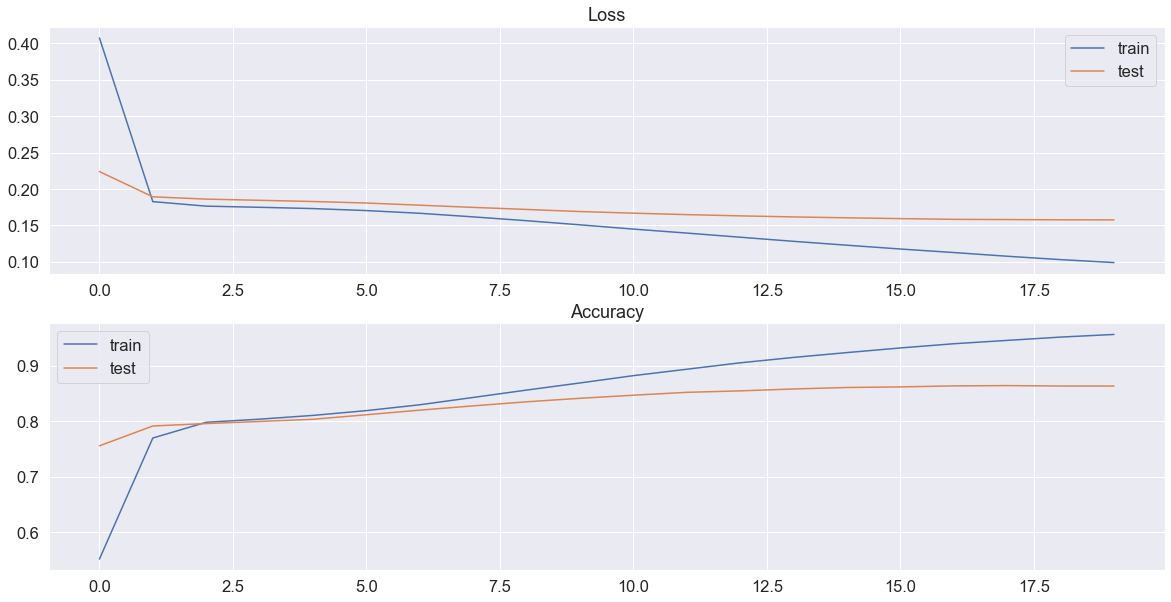

In [38]:
# plot loss during training
from matplotlib.pyplot import figure

figure(figsize=(20, 10))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.legend()
plt.show()

In [39]:
# prediction 
pred = model.predict(padded_test)
pred

array([[0.03455701, 0.04136905, 0.01346529, ..., 0.00908908, 0.0171656 ,
        0.00580862],
       [0.01372424, 0.03049907, 0.01234743, ..., 0.00368449, 0.00191364,
        0.0030953 ],
       [0.16194412, 0.72277796, 0.08857539, ..., 0.01706898, 0.01387697,
        0.01417482],
       ...,
       [0.408899  , 0.22202373, 0.07720461, ..., 0.06922409, 0.0151515 ,
        0.05045664],
       [0.14850771, 0.5794281 , 0.09883246, ..., 0.03995535, 0.01497304,
        0.01563126],
       [0.02147371, 0.86056864, 0.07998052, ..., 0.0129461 , 0.01403874,
        0.00850719]], dtype=float32)

In [40]:
# accuracy 
train_acc = model.evaluate(padded_train, y_train, verbose=0)
test_acc = model.evaluate(padded_test, y_test, verbose=0)
print(train_acc[1])
print(test_acc[1])

0.946491003036499
0.8710029125213623


In [41]:
chakin.search(lang='English')  # lists available indices in English

                   Name  Dimension                     Corpus VocabularySize  \
2          fastText(en)        300                  Wikipedia           2.5M   
11         GloVe.6B.50d         50  Wikipedia+Gigaword 5 (6B)           400K   
12        GloVe.6B.100d        100  Wikipedia+Gigaword 5 (6B)           400K   
13        GloVe.6B.200d        200  Wikipedia+Gigaword 5 (6B)           400K   
14        GloVe.6B.300d        300  Wikipedia+Gigaword 5 (6B)           400K   
15       GloVe.42B.300d        300          Common Crawl(42B)           1.9M   
16      GloVe.840B.300d        300         Common Crawl(840B)           2.2M   
17    GloVe.Twitter.25d         25               Twitter(27B)           1.2M   
18    GloVe.Twitter.50d         50               Twitter(27B)           1.2M   
19   GloVe.Twitter.100d        100               Twitter(27B)           1.2M   
20   GloVe.Twitter.200d        200               Twitter(27B)           1.2M   
21  word2vec.GoogleNews        300      

In [42]:
# Specify English embeddings file to download and install by index number, number of dimensions, and subfoder name
# Note that GloVe 50-, 100-, 200-, and 300-dimensional folders are downloaded with a single zip download
CHAKIN_INDEX = 11
NUMBER_OF_DIMENSIONS = 50
SUBFOLDER_NAME = "gloVe.6B"

In [43]:
DATA_FOLDER = "embeddings"
ZIP_FILE = os.path.join(DATA_FOLDER, "{}.zip".format(SUBFOLDER_NAME))
ZIP_FILE_ALT = "glove" + ZIP_FILE[5:]  # sometimes it's lowercase only...
UNZIP_FOLDER = os.path.join(DATA_FOLDER, SUBFOLDER_NAME)
if SUBFOLDER_NAME[-1] == "d":
    GLOVE_FILENAME = os.path.join(
        UNZIP_FOLDER, "{}.txt".format(SUBFOLDER_NAME))
else:
    GLOVE_FILENAME = os.path.join(UNZIP_FOLDER, "{}.{}d.txt".format(
        SUBFOLDER_NAME, NUMBER_OF_DIMENSIONS))


if not os.path.exists(ZIP_FILE) and not os.path.exists(UNZIP_FOLDER):
    # GloVe by Stanford is licensed Apache 2.0:
    #     https://github.com/stanfordnlp/GloVe/blob/master/LICENSE
    #     http://nlp.stanford.edu/data/glove.twitter.27B.zip
    #     Copyright 2014 The Board of Trustees of The Leland Stanford Junior University
    print("Downloading embeddings to '{}'".format(ZIP_FILE))
    chakin.download(number=CHAKIN_INDEX, save_dir='./{}'.format(DATA_FOLDER))
else:
    print("Embeddings already downloaded.")

if not os.path.exists(UNZIP_FOLDER):
    import zipfile
    if not os.path.exists(ZIP_FILE) and os.path.exists(ZIP_FILE_ALT):
        ZIP_FILE = ZIP_FILE_ALT
    with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
        print("Extracting embeddings to '{}'".format(UNZIP_FOLDER))
        zip_ref.extractall(UNZIP_FOLDER)
else:
    print("Embeddings already extracted.")

print('\nRun complete')

# After this step there should be
# embeddings folder in the current working directory A
# Directory called glove.6b within embeddings directory
# 4 files within it

Embeddings already downloaded.
Embeddings already extracted.

Run complete


In [44]:
from numpy import array
from numpy import asarray
from numpy import zeros
# Select the pre-defined embeddings source        
# Define vocabulary size for the language model    
# Create a wembedding_dict for GloVe.6B.50d

embeddings_dictionary = dict()

glove_file = open("glove.6B.50d.txt",encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((max_words, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### LSTM MODEL

In [45]:
# create LSTM model

deep_inputs = Input(shape=(29,))
embedding_layer = Embedding(max_words, 50, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(40, activation='sigmoid')(LSTM_Layer_1)
LSTM = Model(inputs=deep_inputs, outputs=dense_layer_1)
LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
LSTM.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 29, 50)            747400    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
Total params: 844,208
Trainable params: 96,808
Non-trainable params: 747,400
_________________________________________________________________


In [46]:
# fit LSTM model
LSTM_hist = LSTM.fit(padded_train, y_train, 
                     validation_data=(padded_test, y_test),
                     class_weight  = class_weights,
                     batch_size=32, 
                     epochs=25, 
                     validation_split=0.2)

Epoch 1/25
137/137 [==============================] - 4s 19ms/step - loss: 0.3156 - auc_1: 0.6413 - val_loss: 0.1812 - val_auc_1: 0.7871
Epoch 2/25
137/137 [==============================] - 2s 17ms/step - loss: 0.1775 - auc_1: 0.7911 - val_loss: 0.1812 - val_auc_1: 0.7867
Epoch 3/25
137/137 [==============================] - 2s 17ms/step - loss: 0.1770 - auc_1: 0.7903 - val_loss: 0.1810 - val_auc_1: 0.7894
Epoch 4/25
137/137 [==============================] - 3s 19ms/step - loss: 0.1785 - auc_1: 0.7892 - val_loss: 0.1807 - val_auc_1: 0.7913
Epoch 5/25
137/137 [==============================] - 3s 20ms/step - loss: 0.1782 - auc_1: 0.7886 - val_loss: 0.1812 - val_auc_1: 0.7888
Epoch 6/25
137/137 [==============================] - 3s 20ms/step - loss: 0.1768 - auc_1: 0.7878 - val_loss: 0.1812 - val_auc_1: 0.7888
Epoch 7/25
137/137 [==============================] - 3s 20ms/step - loss: 0.1783 - auc_1: 0.7907 - val_loss: 0.1809 - val_auc_1: 0.7900
Epoch 8/25
137/137 [=====================

In [47]:
# LSTM prediction
pred_lstm= LSTM.predict(padded_test)
pred_lstm

array([[0.1525929 , 0.27815896, 0.04396117, ..., 0.02082542, 0.00783482,
        0.01206085],
       [0.15806633, 0.27940682, 0.04581174, ..., 0.02169707, 0.00740767,
        0.0115073 ],
       [0.15803385, 0.27596185, 0.0442915 , ..., 0.02254212, 0.00745249,
        0.01145169],
       ...,
       [0.16260266, 0.27463752, 0.04670727, ..., 0.02291912, 0.00755227,
        0.01166707],
       [0.1569145 , 0.27610275, 0.04560044, ..., 0.02201056, 0.00777304,
        0.01226479],
       [0.15847495, 0.2767485 , 0.04587272, ..., 0.02159423, 0.00757211,
        0.01189572]], dtype=float32)

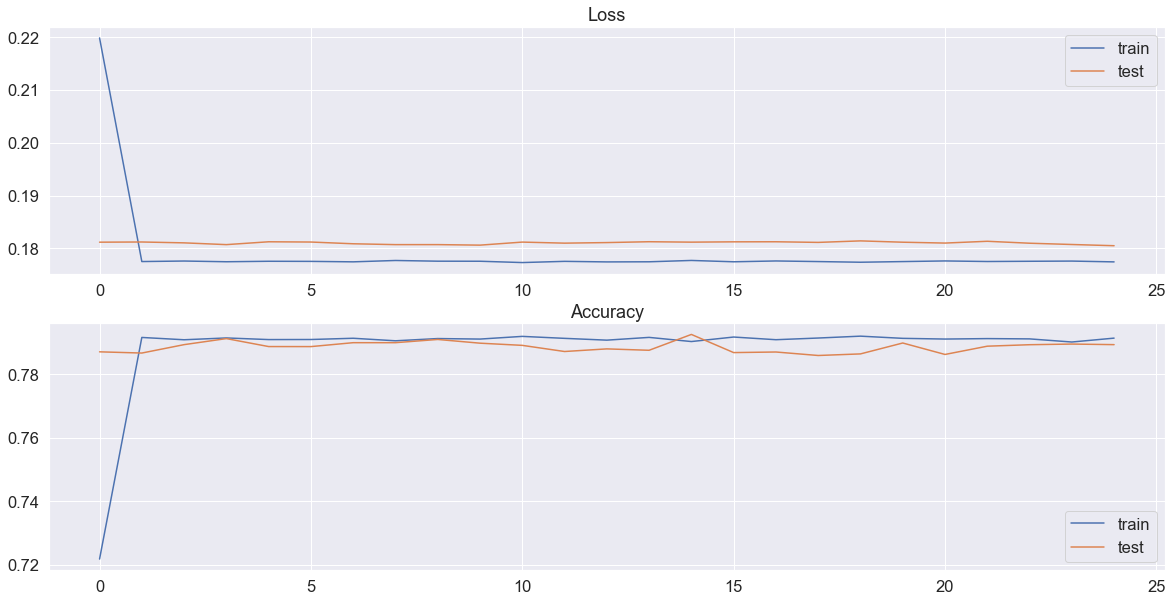

In [48]:
# plot loss during training
figure(figsize=(20, 10))
plt.subplot(211)
plt.title('Loss')
plt.plot(LSTM_hist.history['loss'], label='train')
plt.plot(LSTM_hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(LSTM_hist.history['auc_1'], label='train')
plt.plot(LSTM_hist.history['val_auc_1'], label='test')
plt.legend()
plt.show()

In [49]:
# calculate accuracy for train set and test set 
train_lstm_acc = LSTM.evaluate(padded_train, y_train, verbose=0)
test_lstm_acc = LSTM.evaluate(padded_test, y_test, verbose=0)
print(train_lstm_acc[1])
print(test_lstm_acc[1])

0.7917252779006958
0.7960331439971924


### GRU Model

In [50]:
# Creat GRU model
embedding_layer = Embedding(max_words, 50, weights=[embedding_matrix], trainable=False)(deep_inputs)
GRU_Layer_1 = GRU(128)(embedding_layer)
dense_layer_1 = Dense(40, activation='sigmoid')(GRU_Layer_1)
GRU = Model(inputs=deep_inputs, outputs=dense_layer_1)
GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
GRU.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 29, 50)            747400    
_________________________________________________________________
gru (GRU)                    (None, 128)               69120     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5160      
Total params: 821,680
Trainable params: 74,280
Non-trainable params: 747,400
_________________________________________________________________


In [51]:
# fit GRU model
GRU_hist = GRU.fit(padded_train, y_train, 
                    class_weight  = class_weights,
                    batch_size=32, 
                    epochs=12, 
                    validation_split=0.2)

Epoch 1/12
137/137 [==============================] - 4s 20ms/step - loss: 0.3592 - auc_2: 0.6267 - val_loss: 0.1807 - val_auc_2: 0.7901
Epoch 2/12
137/137 [==============================] - 2s 17ms/step - loss: 0.1769 - auc_2: 0.7924 - val_loss: 0.1790 - val_auc_2: 0.7950
Epoch 3/12
137/137 [==============================] - 3s 18ms/step - loss: 0.1741 - auc_2: 0.8041 - val_loss: 0.1750 - val_auc_2: 0.8097
Epoch 4/12
137/137 [==============================] - 3s 19ms/step - loss: 0.1708 - auc_2: 0.8192 - val_loss: 0.1694 - val_auc_2: 0.8277
Epoch 5/12
137/137 [==============================] - 3s 20ms/step - loss: 0.1628 - auc_2: 0.8373 - val_loss: 0.1615 - val_auc_2: 0.8514
Epoch 6/12
137/137 [==============================] - 3s 20ms/step - loss: 0.1567 - auc_2: 0.8586 - val_loss: 0.1565 - val_auc_2: 0.8664
Epoch 7/12
137/137 [==============================] - 3s 19ms/step - loss: 0.1504 - auc_2: 0.8780 - val_loss: 0.1538 - val_auc_2: 0.8757
Epoch 8/12
137/137 [=====================

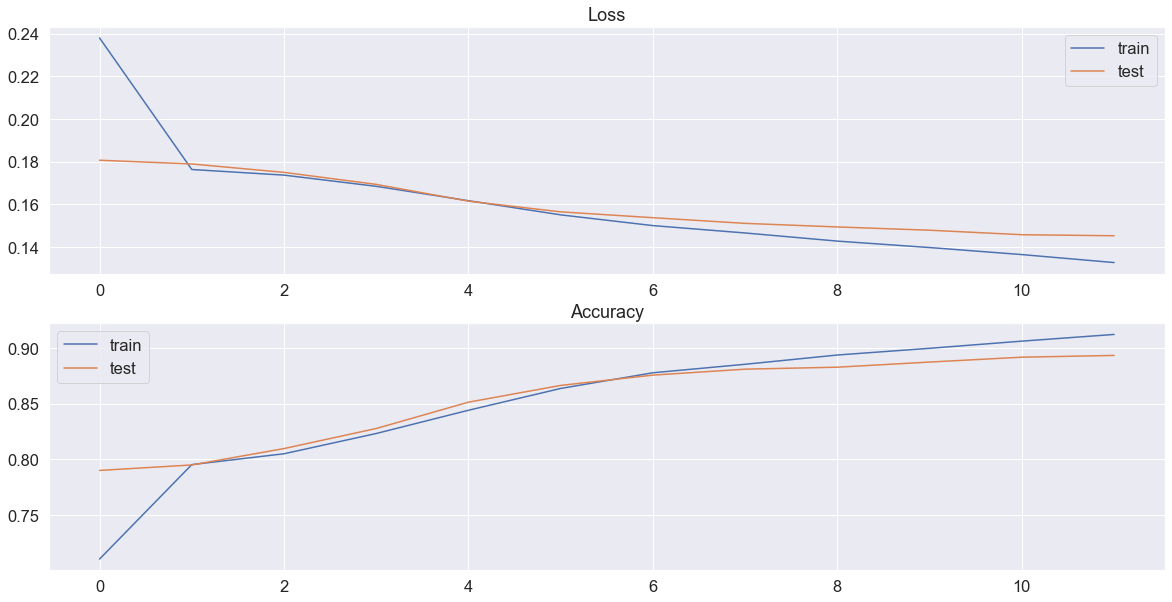

In [52]:
# plot loss during training
figure(figsize=(20, 10))
plt.subplot(211)
plt.title('Loss')
plt.plot(GRU_hist.history['loss'], label='train')
plt.plot(GRU_hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(GRU_hist.history['auc_2'], label='train')
plt.plot(GRU_hist.history['val_auc_2'], label='test')
plt.legend()
plt.show()

In [53]:
# calculate accuracy for train set and test set
train_GRU_acc = GRU.evaluate(padded_train, y_train, verbose=0)
test_GRU_acc = GRU.evaluate(padded_test, y_test, verbose=0)
print(train_GRU_acc[1])
print(test_GRU_acc[1])

0.9129241108894348
0.8316975831985474


In [56]:
print('\nMODEL REPORT SUMMARY')
print('{}\t\t\t\t\t {}\t {}'.format('\nMODEL','TRAIN SET','TEST SET'))
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
print('{}\t\t\t\t {:.4f}\t\t {:.4f}\t\t'.format('DL model',train_acc[1],test_acc[1]))
print('{}\t\t\t\t {:.4f}\t\t {:.4f}\t\t'.format('LSTM model',train_lstm_acc[1],test_lstm_acc[1]))
print('{}\t\t\t\t {:.4f}\t\t {:.4f}\t\t'.format('GRU model',train_GRU_acc[1],test_GRU_acc[1]))



MODEL REPORT SUMMARY

MODEL					 TRAIN SET	 TEST SET
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DL model				 0.9465		 0.8710		
LSTM model				 0.7917		 0.7960		
GRU model				 0.9129		 0.8317		


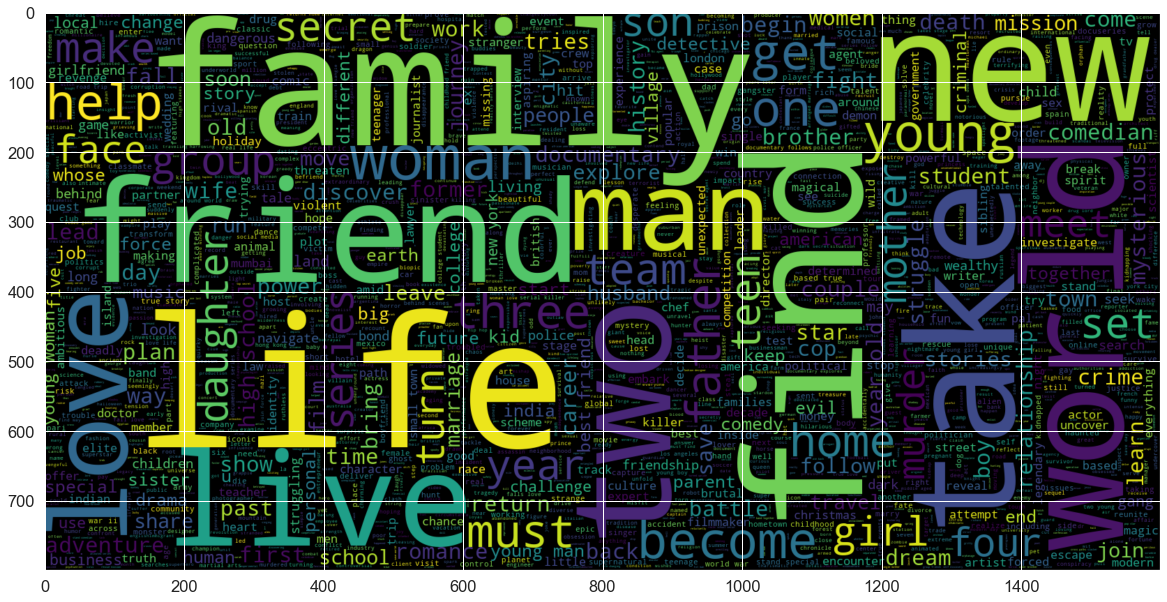

In [55]:
# plot the word cloud for description
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(cat.description))
plt.imshow(wc, interpolation = 'bilinear')